# Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between


### Nerio Moran 23.556.790


Revision de la extraccion de caracteristicas de audio para algoritmos de aprendizaje de maquina.

El procesamiento de voz juega un papel muy importante en alquiera sistema de reconocimiento del habla. Como ejemplo:
- **Reconocimiento de voz**.
- **Reconocimiento del hablante**.

Los coeficientes ceptrales de MEL  **MFCCs** son caracteristicas muy importantes, aunque recientemente los bancos de filtros se han popularizado.

Para este ejemplo se utiliza un archivo de formato wav de 16 bits PCM, llamado "**0SR_US_000_0010_8K.wav**", el cual tiene una frecuencia de muestreo de **8000 Hz**. El archivo es un audio limpio con sentencias y algunas pausas. Por simplicidad se usan los primero **3.5** segundos de audio, que corresponde al tiempo en que se pronuncia la primera oracion o sentencia.


In [75]:

from matplotlib.colors import BoundaryNorm
import librosa
import librosa.display
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import numpy as np

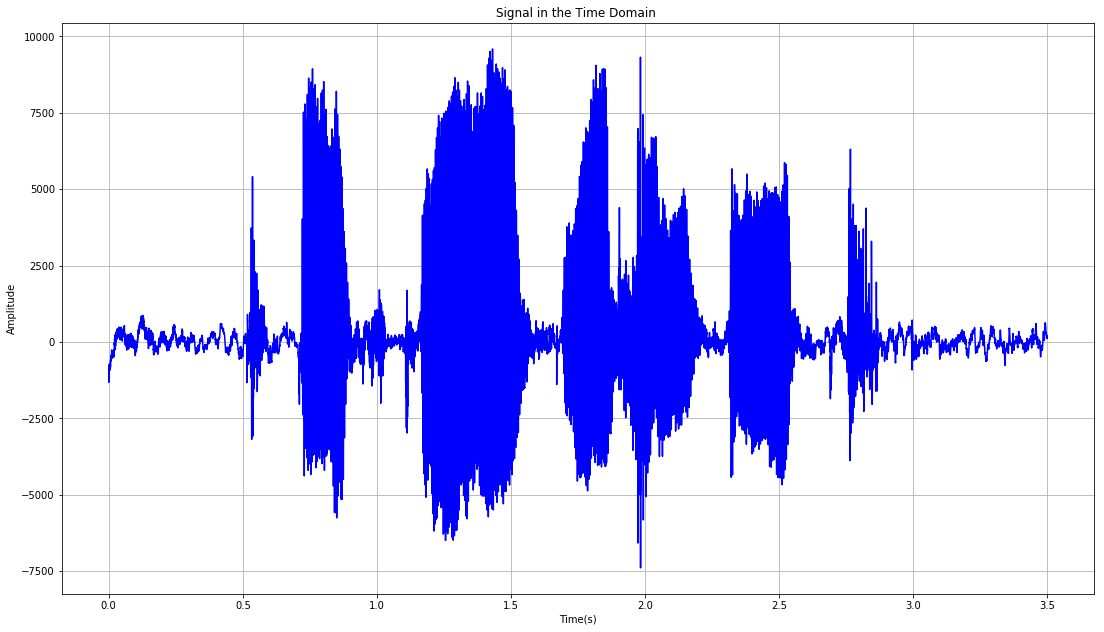

In [57]:

sample_rate, signal = scipy.io.wavfile.read('OSR_us_000_0010_8k.wav')  # File assumed to be in the same directory
signal = signal[0:int(3.5 * sample_rate)]

# plot the wave
time = np.arange(0,len(signal))*(1.0 / sample_rate)


plt.plot(time,signal,'b')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Signal in the Time Domain ")
plt.grid('on')
plt.show()


# Pre-enfasado


El primer paso es aplicar un filtro de pre-enfasado en la señal para amplificar las frecuencias altas. Un de pre-enfasado es bastante util de muchas maneras

- Balancear el espectro de frecuencias, dado que las frecuencias altas usualmente tienen magnitudes menores comparado con las frecuencias bajas.

- Evitar problemas numericos durante la tranformada de fourier.

- Mejora el (SNR) Signal-to-Noise Ratio.


El filtro de pre-enfasado puede ser aplicado a una señal X utilizando un filtro de primer orden como sigue:   **y(t) = X(t) - alfa (X(t-1))**
                                
Los valores tipicos de alfa para procesamiento de voz: **alfa = 0.95 or 0.97**

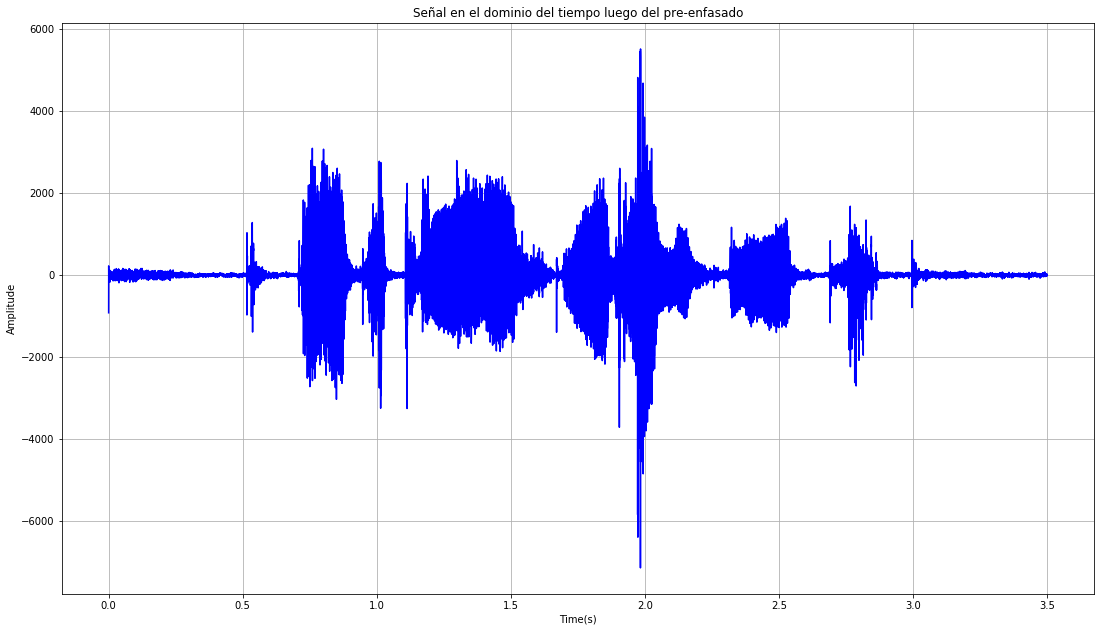

In [58]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])



time = np.arange(0,len(emphasized_signal))*(1.0 / sample_rate)


# Grafica pre-enfasada
plt.plot(time,emphasized_signal,'b')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Señal en el dominio del tiempo luego del pre-enfasado")
plt.grid('on')
plt.show()

# Framming

Luego del pre-enfasado, tenemos que divir la señal en marcos de tiempo corto o "**short-time frames**". La racionalidad detras de esto es que las frecuencias de una señal cambian con respecto al tiempo, entonces en muchos casos no tiene sentido aplicar la transformada de Fourier a lo largo de una señal entero porque podriamos perder contornos de frecuencia de la señal en el tiempo.

Para evitar esto podemos asumir de manera segura que las frecuencias en una señal son estacionarias sobre un periodo muy corto de tiempo. Sim embargo, haciendo la transformada de Fourier sobre este frame, podemos obtener una buena aproximacion de los contornos de frecuencia mediante la concatenacion de los frames adjacentes.

Los tamaños tipicos de los frames en el procesamiento de voz tienen un rango entre **20ms y 40ms** con 50% (+-10%) de solapamiento entre frames consecutivos. Configuraciones populares son de **25ms** (frame_size) para el tamaño del marco **10ms de paso "stride"** (frame_stride) (**15ms** de solapamiento).

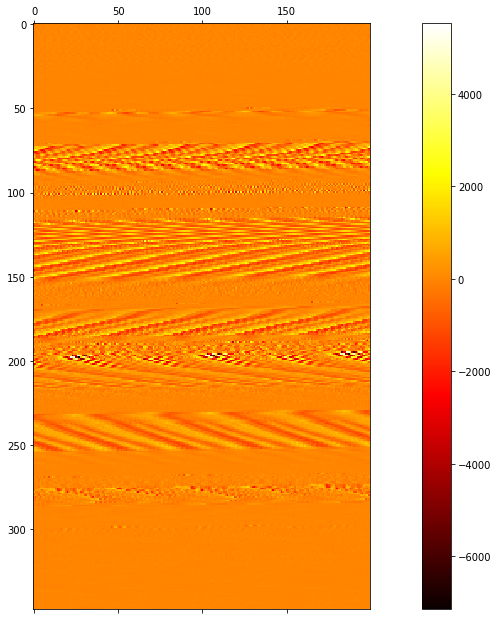

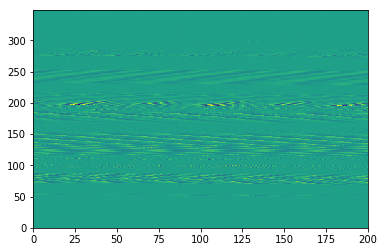

In [59]:


frame_size = 0.025 # Tamaño del marco.
frame_stride = 0.01 # Tamaño el paso.

# Conversion de segundos a muestras "samples"
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
signal_length = len(emphasized_signal) # Longitud de la señal enfasada

frame_length = int(round(frame_length))
frame_step = int(round(frame_step))

# # Make sure that we have at least 1 frame
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  

pad_signal_length = num_frames * frame_step + frame_length

z = numpy.zeros((pad_signal_length - signal_length))

#Pad Signal to make sure that all frames have equal number of 
#samples without truncating any samples from the original signal
pad_signal = numpy.append(emphasized_signal, z)

# Construct an array by repeating A（200） the number of times given by reps（348）.
# 这个写法太妙了。目的：用矩阵来表示帧的次数，348*200，348-总的帧数，200-每一帧的采样数
# 第一帧采样为0、1、2...200;第二帧为80、81、81...280..依次类推
indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)] # Copy of the array indices
# frame：348*200，横坐标348为帧数，即时间；纵坐标200为一帧的200毫秒时间，内部数值代表信号幅度

plt.matshow(frames, cmap='hot')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.colorbar()
plt.figure()
plt.pcolormesh(frames)

plt.show()

# Window

Despues de divir la señal en frames, aplicamos una funcion de ventana (window function), en este caso "window Hamming" para cada frame.

La ventana de hamming tiene la siguiente forma: **W[n] = 0.54 - 0.46 * cos((2 * pi * n) / (frame_length - 1))**. Donde frame_length es la longitud de la ventana.

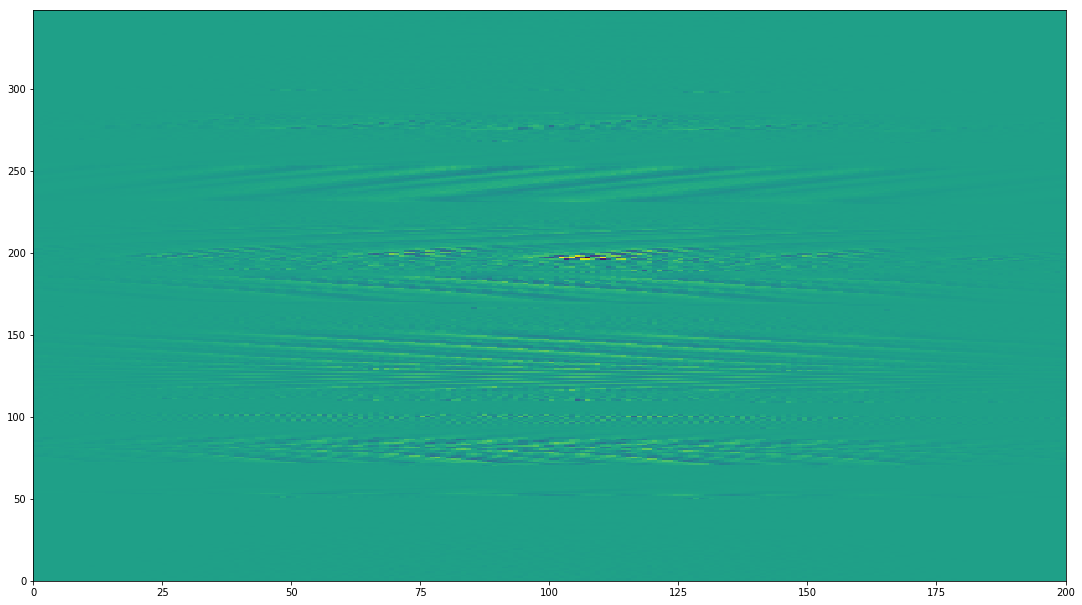

In [60]:

# 第四步、加汉明窗
# 傅里叶变换默认操作的时间段内前后端点是连续的，即整个时间段刚好是一个周期，
# 但是，显示却不是这样的。所以，当这种情况出现时，仍然采用FFT操作时，
# 就会将单一频率周期信号认作成多个不同的频率信号的叠加，而不是原始频率，这样就差生了频谱泄漏问题

frames *= numpy.hamming(frame_length) # 相乘，和卷积类似
# # frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

plt.pcolormesh(frames)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()



# Transformada de Fourier y Spectrograma


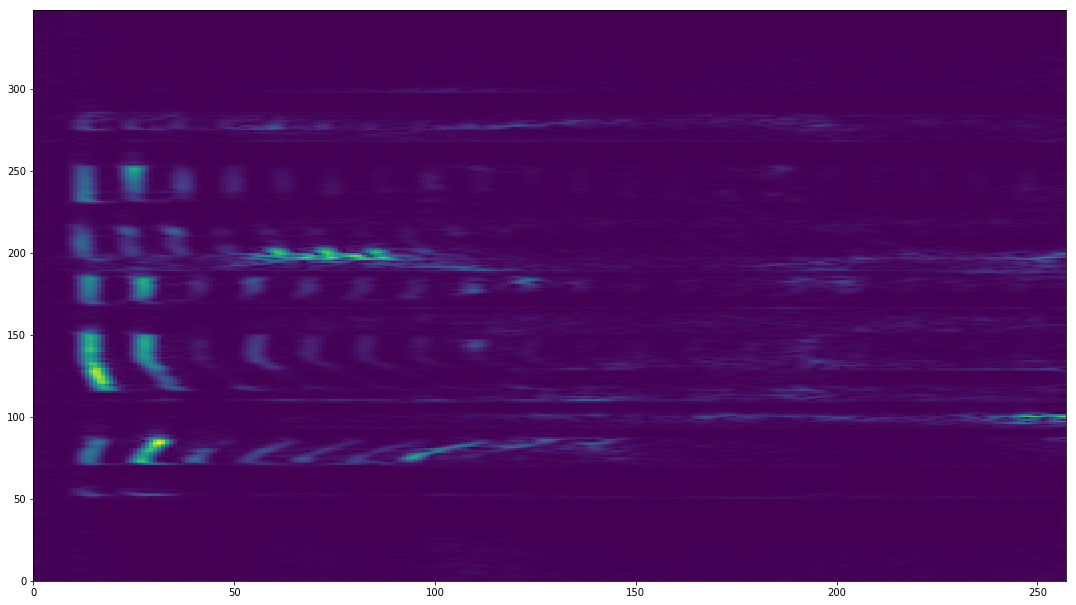

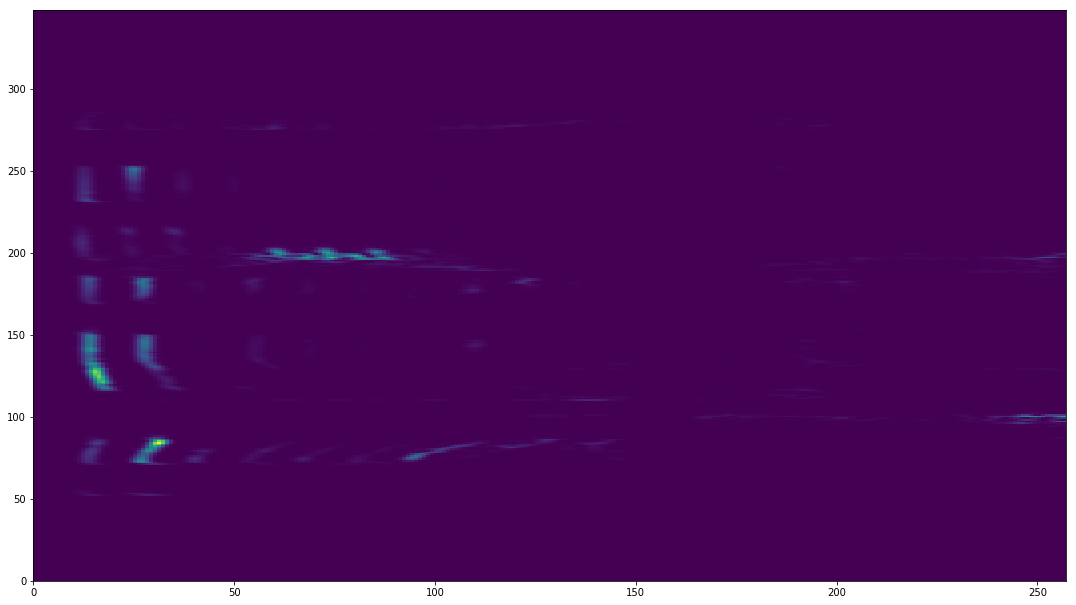

In [61]:

# 第五步-傅里叶变换频谱和能量谱

# _raw_fft扫窗重叠，将348*200，扩展成348*512
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.pcolormesh(mag_frames)

#plt.pcolormesh(pow_frames)

plt.show()


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#plt.pcolormesh(mag_frames)

plt.pcolormesh(pow_frames)

plt.show()

# Bancos de filtros

El paso final para calcular los bancos de prueba es la aplicacion de filtros triangulares, tipicamente 40 filtros, nfit = 40 sobre una escala de MEl para el "Power Spectrum" para extraer las bandas de frecuencia.


La escala de Mel intenta imitar la percepcion no-lineal del sonido del odio, siendo mas discriminativo en bajas frecuencias y menos discriminativo en altas frecuencias. 

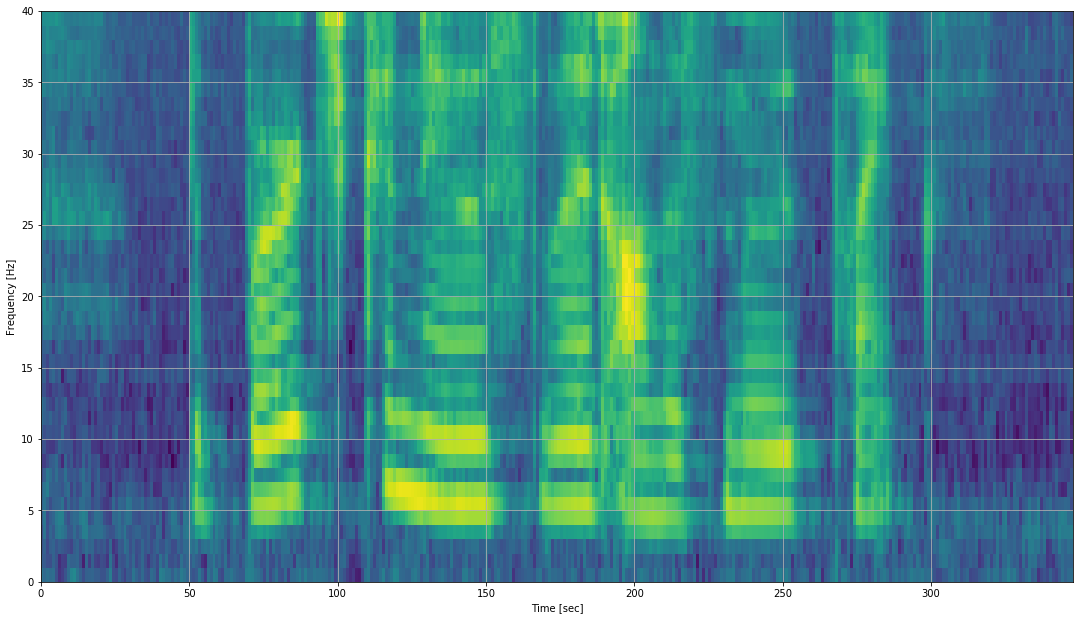

In [62]:

# 第六步，Filter Banks滤波器组
# 公式：m=2595*log10(1+f/700)；f=700(10^(m/2595)−1)
nfilt = 40 #窗的数目
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB;348*26

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.subplot(111)
plt.pcolormesh(filter_banks.T)
plt.grid('on')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()



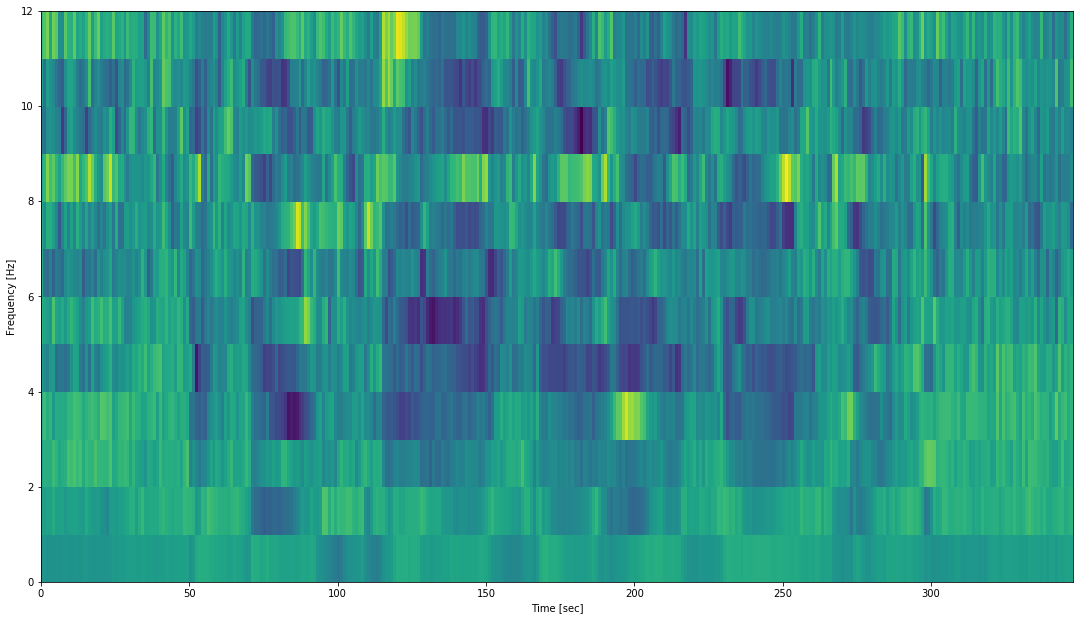

In [63]:

#
# 第七步，梅尔频谱倒谱系数-MFCCs
num_ceps = 12 #取12个系数
cep_lifter=22 #倒谱的升个数？？
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift  #*


#print(mfcc[0:1])

plt.pcolormesh(mfcc.T)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


# Mean Normalization

To balance the spectrum and improve the Signal-to-Noise (SNR), we can simply subtract the mean of each coefficient from all frames.


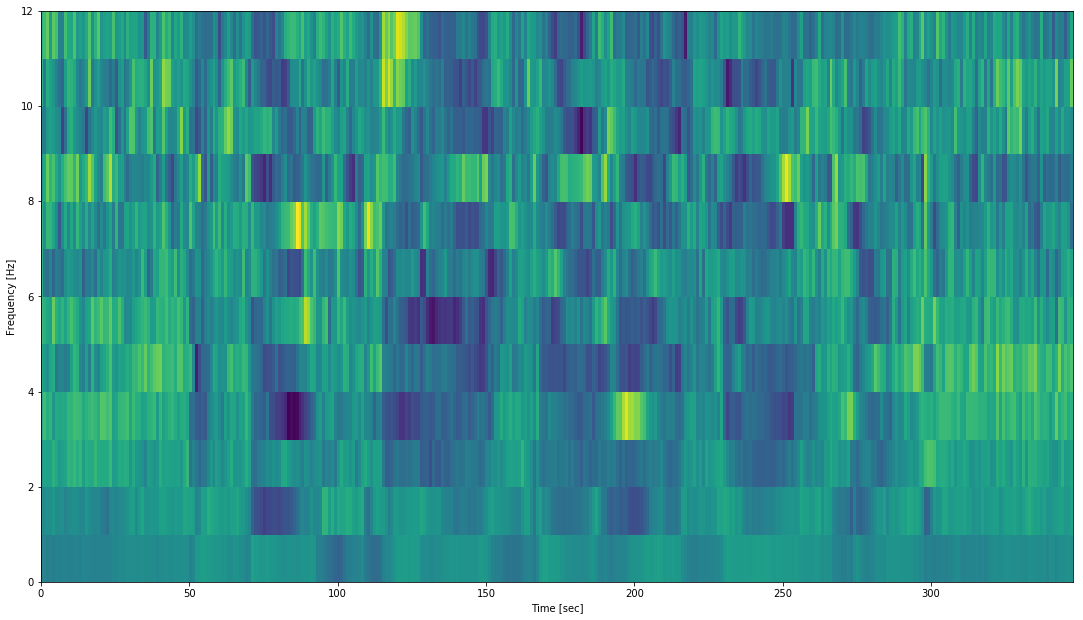

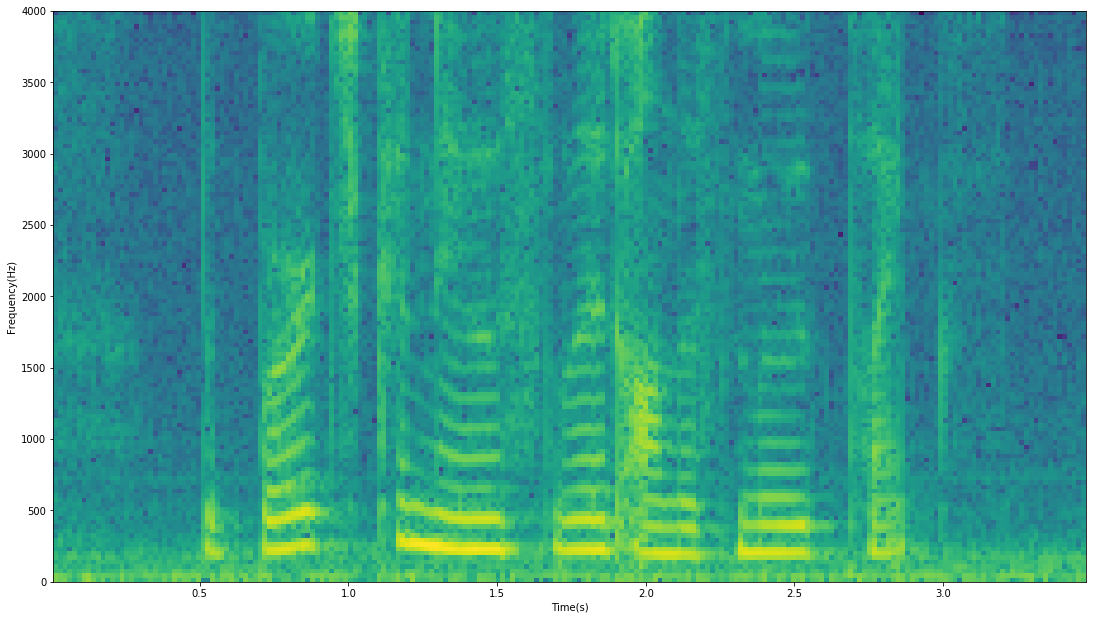

In [73]:


filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)

plt.subplot(111)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.pcolormesh(mfcc.T)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


#d = signal.sum(axis=1) / 2


# plot the wave
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.specgram(signal,Fs = sample_rate, scale_by_freq = True, sides = 'default')
plt.ylabel('Frequency(Hz)')
plt.xlabel('Time(s)')
plt.show()





#fig = plt.gcf()
#fig.set_size_inches(18.5, 10.5)
#mfccs = librosa.feature.melspectrogram(signal,sr=sample_rate,n_fft=512,n_mels=40)
#librosa.display.specshow(mfccs, x_axis='time')
#plt.colorbar()
#plt.title('MFCC')
#plt.tight_layout()
#plt.show()